In [1]:
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import collections
import copy
import random as rd

In [2]:
dataset = pd.read_excel('Data Latih BDC.xlsx')
dataset.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [3]:
slangWord = pd.read_csv('colloquial-indonesian-lexicon.csv')
replaced = slangWord.iloc[:,1].values.tolist()
slangWord = slangWord.iloc[:,0].values.tolist()
dataset = pd.read_excel('Data Latih BDC.xlsx')
datasetJudul = dataset.judul
dataset = dataset.iloc[:,[4,1]]
for i in range(len(dataset)):
    dataset.iloc[i,0] = dataset.iloc[i,0] + " " + datasetJudul[i]
dataset.head()

,narasi,label
0,A caller to a radio talk show recently shared ...,1
1,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,1
2,Jokowi adalah presiden terbaik dlm sejarah ban...,1
3,"Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",1
4,Kadrun kalo lihat foto ini panas dingin . . Fo...,1


In [4]:
def cleaning(text):
    temp = re.sub(r'@[A-Za-z0-9]+', '', text)
    temp = re.sub("[^a-zA-Z]", " ", temp)
    temp = " ".join(temp.split())
    return temp.lower()

def removeStopword(x):
#     return " ".join([w for w in x.split() if not w in dictStopword])
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    return stopword.remove(x)

def removeSlang(x):
    temp = [w for w in x if  w in slangWord]
    for item in temp:
        idxSlang = slangWord.index(item)
        idxReplace = x.index(item)
        x[idxReplace] = replaced[idxSlang]
    return x

def stemming(x):
    # import StemmerFactory class
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(x)

def cleanAll(x):
    x = cleaning(x)
    x = removeStopword(x)
    x = stemming(x)
    x = removeSlang(x.split())
    return " ".join(x)

from tqdm import trange, tqdm
for i in trange(len(dataset)):
    dataset['narasi'].iloc[i] = cleanAll(dataset['narasi'].loc[i])

  0%|                                                                                         | 0/4231 [00:00<?, ?it/s]C:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
100%|██████████████████████████████████████████████████████████████████████████████| 4231/4231 [00:53<00:00, 78.81it/s]


Counter({1: 3465, 0: 766})

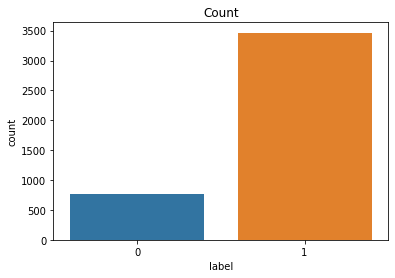

In [5]:
sns.countplot(dataset.label)
plt.xlabel('label')
plt.title('Count')
collections.Counter(dataset.label)

In [6]:
backupDataset = copy.deepcopy(dataset)

In [7]:
dataset = copy.deepcopy(backupDataset)

In [8]:
# Imbalance Class
# Resampling (duplikat seluruh data dengan label 0)

idxTemp = dataset.index[dataset['label'] == 0].tolist()
rd.shuffle(idxTemp)
idxTemp = idxTemp[:300]
insertThis = dataset.iloc[idxTemp]
dataset = pd.concat([dataset, insertThis]) 
# dataset = dataset.reset_index()

Counter({1: 3465, 0: 1066})

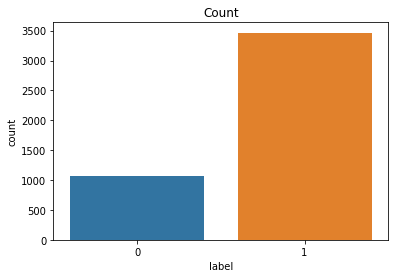

In [9]:
sns.countplot(dataset.label)
plt.xlabel('label')
plt.title('Count')
collections.Counter(dataset.label)

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
dataTrain, dataTest = train_test_split(dataset, test_size=0.1)
# dataTrain

In [11]:
# Feature Extraction

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVect = TfidfVectorizer()
tfidfVect.fit(dataset['narasi'])
tfidfXTrain = tfidfVect.transform(dataTrain['narasi'])
tfidfXTest = tfidfVect.transform(dataTest['narasi'])
YTrain = dataTrain['label'].to_numpy()
YTest = dataTest['label'].to_numpy()

In [13]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
classifier = SVC( kernel='poly', random_state=1)
classifier.fit(tfidfXTrain, YTrain)
YPred = classifier.predict(tfidfXTest)

In [14]:
print('presisi  :',round(precision_score(YTest, YPred, average='macro')*100, 2),'%')
print('recall   :',round(recall_score(YTest, YPred, average='macro')*100, 2),'%')
print('f1 score :',round(f1_score(YTest, YPred, average='macro')*100, 2),'%')

presisi  : 93.27 %
recall   : 74.77 %
f1 score : 79.52 %


In [15]:
evaluateDataTest = copy.deepcopy(dataTest)
evaluateDataTest.insert(2, "Prediction", YPred)
evaluateDataTest.insert(3, "Hasil Akhir", YPred==YTest)
# evaluateDataTest.to_excel("Hasil Akhir.xlsx")

In [16]:
evaluateDataTest.loc[evaluateDataTest['Hasil Akhir'] == True][:10]

,narasi,label,Prediction,Hasil Akhir
3183,catet biar enggak tercyduk catet biar enggak t...,0,0,True
2732,psbb kota bandung raya senin jam wib liar psbb...,1,1,True
3346,ellen degeneres distributes help for corona vi...,1,1,True
69,demo neo pki sudah ijin buntel kentut maaf ral...,1,1,True
1132,uang italian millionaire terjun bagunan keluar...,1,1,True
1700,dokter israel bantu rrc tentang wabah virus co...,1,1,True
436,jack sama advice hopefully we can get through ...,1,1,True
1826,info brsan daerah bago rs bayangkara timur tua...,1,1,True
2002,fbi umum tangkap profesor harvard ketua biolog...,1,1,True
2963,ekor yang mati sudah kalang kabut bgamna denga...,1,1,True


In [17]:
evaluateDataTest.loc[evaluateDataTest['Hasil Akhir'] == False][:10]

,narasi,label,Prediction,Hasil Akhir
662,menteri negeri klarifikasi anak anak wni tahan...,0,1,False
3507,berita tulis alir sesat tahun an alir sesat re...,0,1,False
3901,washington senin paul manafort mantan manajer ...,0,1,False
549,hadir misi ustad bachtiar nasir aql fpi ustad ...,0,1,False
1062,massa istiqlal istiqlal gembok masjid istiqlal...,0,1,False
524,wenang sih mantan jenderal sengak luhut larang...,0,1,False
915,edar isu media sosial beranta rencana naik har...,0,1,False
2209,sumber darimana video ungsi syria lempari rece...,0,1,False
2375,info kemudi mobil hati hati parkir kendara tem...,0,1,False
3753,foto acara munas partai hanura bal perhati fot...,0,1,False


Counter({0: 107, 1: 347})

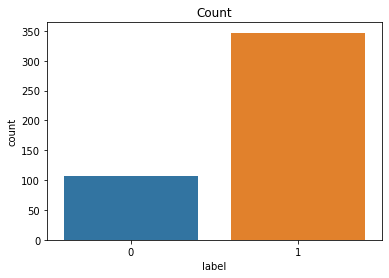

In [18]:
sns.countplot(evaluateDataTest.label)
plt.xlabel('label')
plt.title('Count')
collections.Counter(evaluateDataTest.label)

Counter({0: 53, 1: 401})

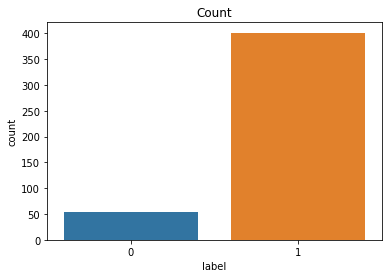

In [19]:
sns.countplot(evaluateDataTest.Prediction)
plt.xlabel('label')
plt.title('Count')
collections.Counter(evaluateDataTest.Prediction)